In [47]:
import numpy as np
import pandas as pd
import h5py
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from torch.utils.data import Dataset, DataLoader

In [65]:
if torch.cuda.is_available():
    dev = "cuda:0"
    print("running on GPU")
else:
    print("running on CPU")
    dev = "cpu"
    
device = torch.device(dev)

running on CPU


In [48]:
class train_dataset(Dataset):
    def __init__(self):
        data = np.loadtxt('./data/train_data.txt', dtype=np.float32, delimiter=",", skiprows=1)
        self.x = torch.tensor(data[:, 1:-6])
        self.y = torch.tensor(data[:, [-1]])
        self.n_samples = data.shape[0]
        
    def __getitem__(self, index):
        return self.x[index], self.y[index]
        
    def __len__(self):
        return self.n_samples

In [49]:
train_data = train_dataset()

In [50]:
val_data = np.loadtxt('./data/val_data.txt', dtype=np.float32, delimiter=",", skiprows=1)
val_input = torch.tensor(val_data[:, 1:-6]).to(device)
val_labels = torch.tensor(val_data[:, -1]).to(device)
test_data = np.loadtxt('./data/test_data.txt', dtype=np.float32, delimiter=",", skiprows=1)
test_input = torch.tensor(test_data[:, 1:-6]).to(device)
test_labels = torch.tensor(test_data[:, -1]).to(device)

In [69]:
model = torch.nn.Sequential(
    torch.nn.Linear(26, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 1),
    torch.nn.Sigmoid()
)

model = model.to(device)
loss_fn = torch.nn.BCELoss()

In [70]:
learning_rate = 0.1
epochs = 200
iterations = 8
batch_size = int(train_data.__len__()/iterations)
print(batch_size)

train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, drop_last=True)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

151223


epoch: 0, loss: 0.6259, accuracy: 0.7838, AUC: 0.8619, background rejection at 30 percent: 18.8137
epoch: 20, loss: 0.2414, accuracy: 0.9063, AUC: 0.9589, background rejection at 30 percent: 92.5549
epoch: 40, loss: 0.2187, accuracy: 0.9101, AUC: 0.9678, background rejection at 30 percent: 181.5212
epoch: 60, loss: 0.2052, accuracy: 0.9165, AUC: 0.9721, background rejection at 30 percent: 235.9988
epoch: 80, loss: 0.1977, accuracy: 0.9209, AUC: 0.9740, background rejection at 30 percent: 266.6318
epoch: 100, loss: 0.1936, accuracy: 0.9224, AUC: 0.9750, background rejection at 30 percent: 283.5310
epoch: 120, loss: 0.1909, accuracy: 0.9232, AUC: 0.9757, background rejection at 30 percent: 315.0344
epoch: 140, loss: 0.1890, accuracy: 0.9239, AUC: 0.9762, background rejection at 30 percent: 346.4836
epoch: 160, loss: 0.1875, accuracy: 0.9244, AUC: 0.9766, background rejection at 30 percent: 373.4824
epoch: 180, loss: 0.1863, accuracy: 0.9249, AUC: 0.9769, background rejection at 30 percen

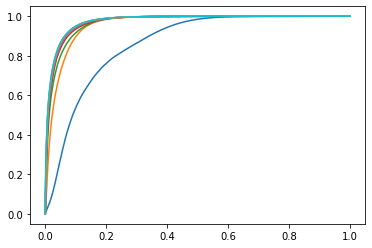

In [71]:
loss_train_arr = []
loss_val_arr = []
acc_arr = []
auc_arr = []
bkg_rej = []
for e in range(epochs):
    loss_sum = 0
    for i, (train_input, train_label) in enumerate(train_loader):
        train_input = train_input.to(device)
        train_label = train_label.to(device)
        label_pred = model(train_input)
        loss_train = loss_fn(label_pred, train_label.reshape(-1, 1))
        loss_sum += loss_train.item()
        
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
    
    with torch.no_grad():
        val_label_pred = model(val_input)
        loss_val = loss_fn(val_label_pred, val_labels.reshape(-1, 1))
        acc_arr.append(1 - torch.sum(torch.abs(val_label_pred.round() - val_labels.reshape(-1, 1))).item()/len(val_labels))
        loss_train_arr.append(loss_sum/iterations)
        loss_val_arr.append(loss_val.item())
        auc_arr.append(roc_auc_score(val_labels.cpu().detach().numpy(), val_label_pred.cpu().detach().numpy()))
        fpr, tpr, thresholds = roc_curve(val_labels.cpu().detach().numpy(), val_label_pred.cpu().detach().numpy())
        bkg_rej.append(1/fpr[np.argmin(np.abs(tpr-0.3))])
                
    if e % 20 == 0:
        print("epoch: %d, loss: %.4f, accuracy: %.4f, AUC: %.4f, background rejection at 30 percent: %.4f" % (e, loss_sum/iterations, acc_arr[e], auc_arr[e], bkg_rej[e]))
        plt.plot(fpr, tpr) 

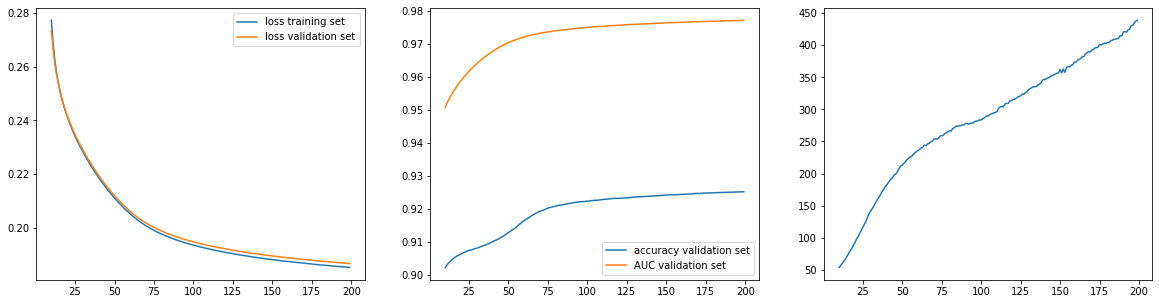

In [72]:
cut_epochs = 10

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

ax1.plot(range(epochs)[cut_epochs:], loss_train_arr[cut_epochs:], label='loss training set')
ax1.plot(range(epochs)[cut_epochs:], loss_val_arr[cut_epochs:], label='loss validation set')
ax1.legend(loc='upper right')
ax2.plot(range(epochs)[cut_epochs:], acc_arr[cut_epochs:], label='accuracy validation set')
ax2.plot(range(epochs)[cut_epochs:], auc_arr[cut_epochs:], label='AUC validation set')
ax2.legend(loc='lower right')
ax3.plot(range(epochs)[cut_epochs:], bkg_rej[cut_epochs:])
plt.show()

In [63]:
with torch.no_grad():
    test_label_pred = model(test_input)
    print("accuracy test set: %.4f" % (1 - torch.sum(torch.abs(test_label_pred.round() - test_labels.reshape(-1, 1))).item()/len(test_labels)))
    print("AUC test set: %.4f" % (roc_auc_score(val_labels.cpu().detach().numpy(), val_label_pred.cpu().detach().numpy())))
    fpr, tpr, thresholds = roc_curve(val_labels.cpu().detach().numpy(), val_label_pred.cpu().detach().numpy())
    print("background rejection at 30 percent: %.4f" % (1/fpr[np.argmin(np.abs(tpr-0.3))]))

accuracy test set: 0.9056
AUC test set: 0.9594
background rejection at 30 percent: 91.3786


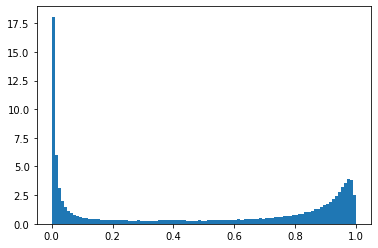

In [64]:
plt.hist(test_label_pred.detach().numpy(), density=True, bins=100)
plt.show()